In [1]:
from pprint import pprint
from pathlib import Path
import pandas as pd
import qlib
import os
from qlib.utils import init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord, SigAnaRecord
from qlib.contrib.report import analysis_model, analysis_position
from qlib.data import D

from lilab.qlib.strategy.meanvar_strategy import MeanVarStrategy
from G4P import G4PModel

qlib.init(provider_uri='~/.qlib/qlib_data/cn_data')

/data2/linaiqi/anaconda3/envs/qlib/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tf_ver: 1.15.0 gpflow_ver: 1.3.0


2024-10-06 16:15:57.827278: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-10-06 16:15:57.864731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299905000 Hz
2024-10-06 16:15:57.870713: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f7a2abda60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-10-06 16:15:57.870763: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-10-06 16:15:57.875213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-10-06 16:15:58.390942: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f7a2b1cf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-06 16:15:58.391002: I tensorflow/compiler/xla/s

avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0
/device:XLA_GPU:1
/device:XLA_GPU:2
/device:XLA_GPU:3


[62117:MainThread](2024-10-06 16:15:58,436) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
INFO:qlib.Initialization:default_conf: client.
[62117:MainThread](2024-10-06 16:15:58,441) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
INFO:qlib.Initialization:qlib successfully initialized based on client settings.
[62117:MainThread](2024-10-06 16:15:58,443) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': PosixPath('/data2/linaiqi/.qlib/qlib_data/cn_data')}
INFO:qlib.Initialization:data_path={'__DEFAULT_FREQ': PosixPath('/data2/linaiqi/.qlib/qlib_data/cn_data')}


In [2]:
MARKET='csi100'
BENCHMARK = "SH000300"
EXP_NAME = 'csi100_G4P'

<AxesSubplot:xlabel='datetime'>

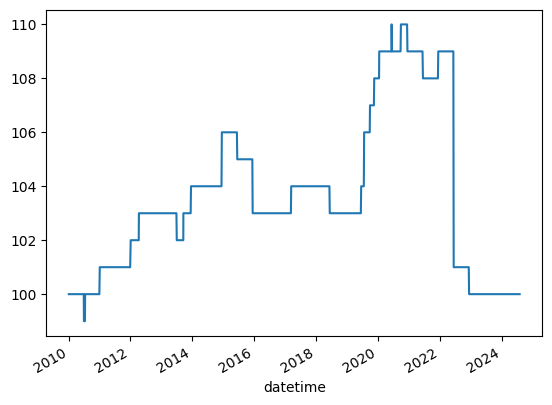

In [3]:
df = D.features(D.instruments(MARKET), ["$close"], start_time="2010-01-01", end_time="2024-08-01")
df.groupby("datetime").size().plot()

In [ ]:
###################################
# prediction, backtest & analysis
###################################
port_analysis_config = {
    "executor": {
        "class": "SimulatorExecutor",
        "module_path": "qlib.backtest.executor",
        "kwargs": {
            "time_per_step": "day",
            "generate_portfolio_metrics": True,
        },
    },
    "strategy": {
        "class": "MeanVarStrategy",
        "module_path": "lilab.qlib.strategy.meanvar_strategy",
        "kwargs": {
            "signal": "<PRED>",
            "risk_gamma": 0.001,
            "expect_r_anual": 0.03,
        },
    },
    "backtest": {
        "start_time": "2023-01-01",
        "end_time": "2024-08-01",
        "account": 100000,
        "benchmark": BENCHMARK,
        "exchange_kwargs": {
            "freq": "day",
            "limit_threshold": 0.095,
            "deal_price": "close",
            "open_cost": 0.0005,
            "close_cost": 0.0015,
            "min_cost": 5,
        },
    },
}

# backtest and analysis
with R.start(experiment_name=EXP_NAME, recorder_id=rid, resume=True):
    # signal-based analysis
    rec = R.get_recorder()
    sar = SigAnaRecord(rec)
    sar.generate()

    #  portfolio-based analysis: backtest
    par = PortAnaRecord(rec, port_analysis_config, "day")
    par.generate()

[62117:MainThread](2024-10-06 16:16:40,939) INFO - qlib.workflow - [exp.py:258] - Experiment 1 starts running ...
INFO:qlib.workflow:Experiment 1 starts running ...
[62117:MainThread](2024-10-06 16:16:40,957) INFO - qlib.workflow - [recorder.py:341] - Recorder 01bc52700d564313a22231a1a42a4aa0 starts running under Experiment 1 ...
INFO:qlib.workflow:Recorder 01bc52700d564313a22231a1a42a4aa0 starts running under Experiment 1 ...
Not a git repository
To compare two paths outside a working tree:
usage: git diff [--no-index] <path> <path>
[62117:MainThread](2024-10-06 16:16:41,038) INFO - qlib.workflow - [recorder.py:374] - Fail to log the uncommitted code of $CWD(/data2/linaiqi/finance/G4PQ) when run git diff.
INFO:qlib.workflow:Fail to log the uncommitted code of $CWD(/data2/linaiqi/finance/G4PQ) when run git diff.
fatal: Not a git repository (or any parent up to mount point /data2)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
[62117:MainThread](2024-10-06 16

{'IC': 0.12045180282298412,
 'ICIR': 0.4584751090132519,
 'Rank IC': 0.13049447337150563,
 'Rank ICIR': 0.4556983807111825}


KeyboardInterrupt: 

In [9]:
# load recorder
recorder = R.get_recorder(recorder_id=rid, experiment_name=EXP_NAME)

In [10]:
# load previous results
pred_df = recorder.load_object("pred.pkl")
report_normal_df = recorder.load_object("portfolio_analysis/report_normal_1day.pkl")
positions = recorder.load_object("portfolio_analysis/positions_normal_1day.pkl")
analysis_df = recorder.load_object("portfolio_analysis/port_analysis_1day.pkl")

In [11]:
# Previous Model can be loaded. but it is not used.
# loaded_model = recorder.load_object("trained_model")
# loaded_model

In [ ]:
analysis_position.report_graph(report_normal_df)

In [ ]:
analysis_position.risk_analysis_graph(analysis_df, report_normal_df)

In [14]:
label_df = dataset.prepare("test").iloc[:,-1]
label_df.columns = ["label"]

In [ ]:
pred_label = pd.concat([label_df, pred_df], axis=1, sort=True).reindex(label_df.index)
analysis_position.score_ic_graph(pred_label)

In [ ]:
analysis_model.model_performance_graph(pred_label)

In [ ]:
from gpflow import settings
import numpy as np
settings.float_type